In [116]:
from scipy.io import loadmat
import numpy as np

data = loadmat('sampleEEGdata.mat')['EEG'][0, 0]
print(data.dtype)
print(data['data'].shape)
channel_locs = data['chanlocs']
print(channel_locs[0, 0].dtype)
x = np.array([channel_locs[0, i]['X'][0][0] for i in range(channel_locs.shape[1])])
y = np.array([channel_locs[0, i]['Y'][0][0] for i in range(channel_locs.shape[1])])
z = np.array([channel_locs[0, i]['Z'][0][0] for i in range(channel_locs.shape[1])])
print(y)
print(z)

[('setname', 'O'), ('filename', 'O'), ('filepath', 'O'), ('subject', 'O'), ('group', 'O'), ('condition', 'O'), ('session', 'O'), ('comments', 'O'), ('nbchan', 'O'), ('trials', 'O'), ('pnts', 'O'), ('srate', 'O'), ('xmin', 'O'), ('xmax', 'O'), ('times', 'O'), ('data', 'O'), ('icaact', 'O'), ('icawinv', 'O'), ('icasphere', 'O'), ('icaweights', 'O'), ('icachansind', 'O'), ('chanlocs', 'O'), ('urchanlocs', 'O'), ('chaninfo', 'O'), ('ref', 'O'), ('event', 'O'), ('urevent', 'O'), ('eventdescription', 'O'), ('epoch', 'O'), ('epochdescription', 'O'), ('reject', 'O'), ('stats', 'O'), ('specdata', 'O'), ('specicaact', 'O'), ('splinefile', 'O'), ('icasplinefile', 'O'), ('dipfit', 'O'), ('history', 'O'), ('saved', 'O'), ('etc', 'O'), ('spedata', 'O')]
(64, 640, 99)
[('labels', 'O'), ('theta', 'O'), ('radius', 'O'), ('X', 'O'), ('Y', 'O'), ('Z', 'O'), ('sph_theta', 'O'), ('sph_phi', 'O'), ('sph_radius', 'O'), ('type', 'O'), ('urchan', 'O')]
[  2.61330144e+01   4.97094313e+01   3.14827968e+01   2.60

In [85]:
from mne.channels import read_montage

montage = read_montage('GSN-HydroCel-257')
print(montage.ch_names)
pos = montage.pos[3:, :]
x, y, z = pos[:, 0], pos[:, 1], pos[:, 2]
print(x)

['FidNz', 'FidT9', 'FidT10', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 'E69', 'E70', 'E71', 'E72', 'E73', 'E74', 'E75', 'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E82', 'E83', 'E84', 'E85', 'E86', 'E87', 'E88', 'E89', 'E90', 'E91', 'E92', 'E93', 'E94', 'E95', 'E96', 'E97', 'E98', 'E99', 'E100', 'E101', 'E102', 'E103', 'E104', 'E105', 'E106', 'E107', 'E108', 'E109', 'E110', 'E111', 'E112', 'E113', 'E114', 'E115', 'E116', 'E117', 'E118', 'E119', 'E120', 'E121', 'E122', 'E123', 'E124', 'E125', 'E126', 'E127', 'E128', 'E129', 'E130', 'E131', 'E132', 'E133', 'E134', 'E135',

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

ax.scatter(x, y, z, color='b')
    
_, _, r = cart2sph(x, y, z)
max_r = np.max(r)
xs = x/r
ys = y/r
zs = z/r

ax.scatter(xs, ys, zs, color='r')
plt.show()
    

In [118]:
import numpy as np
from scipy.special import lpmn
from numpy.linalg import inv

def unit_sphere(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    max_r = np.max(r)
    x /= max_r
    y /= max_r
    z /= max_r
    return x, y, z

@np.vectorize
def vector_legendre(n, x):
    return lpmn(0, n, x)[0][-1, -1]
    
def compute_GH(x, y, z):
    
    num_electrodes = len(x)
    if num_electrodes > 100:
        m = 3
        leg_order = 40
    else:
        m = 4
        leg_order = 20
        
    
    x, y, z = unit_sphere(x, y, z)
    G = np.zeros((num_electrodes, num_electrodes))
    H = np.zeros((num_electrodes, num_electrodes))
    cos_dist = np.zeros((num_electrodes, num_electrodes))
    
    # Compute the Cosine Distance Between Electrodes
    for i in range(num_electrodes):
        for j in range(i+1, num_electrodes):
            cos_dist[i, j] = 1 - (((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2) / 2.)
            
    cos_dist = cos_dist + cos_dist.T + np.identity(num_electrodes)
    
    # Compute the Legendre Polynomials
    leg_poly = np.zeros((leg_order, num_electrodes, num_electrodes))
    for n in range(1, leg_order + 1):
        leg_poly[n-1, :, :] = vector_legendre(n, cos_dist)
    
    for i in range(num_electrodes):
        for j in range(i, num_electrodes):
            
            g = 0
            h = 0
            
            for n in range(1, leg_order+1):
                g += ((2*n + 1) * leg_poly[n-1, i, j]) / ((n * (n + 1))**m)
                h -= ((2*n + 1) * leg_poly[n-1, i, j]) / ((n * (n + 1))**(m - 1))
            
            G[i, j] = g / (4 * np.pi)
            H[i, j] = h / (4 * np.pi)
            
    
    G += G.T
    H += H.T
    
    # ??
#     G -= np.identity(num_electrodes) * G[0, 0] / 2.
#     H -= np.identity(num_electrodes) * H[0, 0] / 2.
    
    return G, H, cos_dist

def laplacian(data, G, H, smoothing=1e-5):
    
    num_electrodes, num_time_points = data.shape
    
    Gs = G + np.identity(num_electrodes) * smoothing
    
    Gi = inv(Gs)
    
    for i in range(num_time_points):
        
    
    
            

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_in = loadmat('sampleEEGdata.mat')['EEG'][0, 0]
channel_locs = data_in['chanlocs']
data = data_in['data'].mean(axis=-1)
times = data_in['times']
print(times)
print(data.shape)
x = np.array([channel_locs[0, i]['X'][0][0] for i in range(channel_locs.shape[1])])
y = np.array([channel_locs[0, i]['Y'][0][0] for i in range(channel_locs.shape[1])])
z = np.array([channel_locs[0, i]['Z'][0][0] for i in range(channel_locs.shape[1])])

G, H, cd = compute_GH(x, y, z)

f, axs = plt.subplots(1, 3)
m1 = axs[0].imshow(G)
m2 = axs[1].imshow(H)
plt.colorbar(m1, ax=axs[0])
plt.colorbar(m2, ax=axs[1])

axs[2].imshow(cd)
plt.tight_layout()
plt.show()

[[-1000.       -996.09375  -992.1875   -988.28125  -984.375    -980.46875
   -976.5625   -972.65625  -968.75     -964.84375  -960.9375   -957.03125
   -953.125    -949.21875  -945.3125   -941.40625  -937.5      -933.59375
   -929.6875   -925.78125  -921.875    -917.96875  -914.0625   -910.15625
   -906.25     -902.34375  -898.4375   -894.53125  -890.625    -886.71875
   -882.8125   -878.90625  -875.       -871.09375  -867.1875   -863.28125
   -859.375    -855.46875  -851.5625   -847.65625  -843.75     -839.84375
   -835.9375   -832.03125  -828.125    -824.21875  -820.3125   -816.40625
   -812.5      -808.59375  -804.6875   -800.78125  -796.875    -792.96875
   -789.0625   -785.15625  -781.25     -777.34375  -773.4375   -769.53125
   -765.625    -761.71875  -757.8125   -753.90625  -750.       -746.09375
   -742.1875   -738.28125  -734.375    -730.46875  -726.5625   -722.65625
   -718.75     -714.84375  -710.9375   -707.03125  -703.125    -699.21875
   -695.3125   -691.40625  -687.5     

NameError: name 'compute_GH' is not defined

(2, 64)


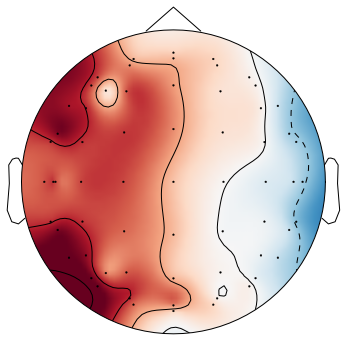

In [2]:
from mne.viz import plot_topomap
import numpy as np

print(np.vstack((x, y)).shape)
plot_topomap(data[:, 321], np.vstack((x, y)).T)
plt.show()